# 树模型

In [1]:
import sys
sys.path.append('/Users/apple/Documents/ML_Project/ML - 2.1/')
import numpy as np
import pandas as pd
from module.utils import *
from ngboost.learners import *
from tqdm.notebook import tqdm as tqdm
from sklearn.metrics.regression import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
def tree_model_plot1(best_param):
    X_train, X_test, Y_train, Y_test, Y_scaler = \
    get_data(hour_num=int(best_param['hour_num']),
             transform=best_param['transform'],
             drop_time=bool(best_param['transform']), 
             scale=True, return_y_scaler=True)
    Y_pred = DecisionTreeRegressor(max_depth=best_param['max_depth']).\
        fit(X_train, Y_train).predict(X_test)
    mse = mean_squared_error(Y_pred, Y_test)
    pd.concat([pd.Series(Y_pred, name='Pred', 
                         index=Y_test.index), Y_test], axis=1)\
    .plot(title='mse:'+str(round(mse, 8))+\
          '   depth:'+str(best_param['max_depth']),
          figsize=(12, 5))

In [18]:
def tree_model_plot2(best_param, drop_minute=False):
    X_train, X_test, Y_train, Y_test, Y_scaler = \
    get_data2(hour_num=int(best_param['hour_num']),
             transform=best_param['transform'],
             drop_time=bool(best_param['transform']),
             drop_else=bool(best_param['drop_else']),
             scale=True, return_y_scaler=True,
              drop_minute=drop_minute)
    Y_pred = DecisionTreeRegressor(max_depth=best_param['max_depth']).\
        fit(X_train, Y_train).predict(X_test)
    mse = mean_squared_error(Y_pred, Y_test)
    pd.concat([pd.Series(Y_pred, name='Pred', 
                         index=Y_test.index), Y_test], axis=1)\
    .plot(title='mse:'+str(round(mse, 8))+\
          '   depth:'+str(best_param['max_depth']),
          figsize=(12, 5))

In [19]:
def tree_heatmap1(mse_df):
    f, ax= plt.subplots(figsize=(15,18),nrows=3)
    sns.heatmap(mse_df.groupby(['transform','hour_num'])['mse'].mean().unstack(),
                ax=ax[0], vmax=0.008, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','max_depth'])['mse'].mean().unstack(),
                ax=ax[1], vmax=0.008, annot=True, fmt='.3f')
    sns.heatmap(mse_df.groupby(['transform','drop_time'])['mse'].mean().unstack(),
            ax=ax[2], vmax=0.008, annot=True, fmt='.5f')

In [20]:
def tree_heatmap2(mse_df):
    f, ax= plt.subplots(figsize=(19,24),nrows=4)
    sns.heatmap(mse_df.groupby(['transform','hour_num'])['mse'].mean().unstack(),
                ax=ax[0], vmax=0.00219, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','max_depth'])['mse'].mean().unstack(),
                ax=ax[1], vmax=0.00007, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_time'])['mse'].mean().unstack(),
                ax=ax[2], vmax=0.00219, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_else'])['mse'].mean().unstack(),
                ax=ax[3], vmax=0.00219, annot=True, fmt='.5f')

In [21]:
def tree_grid_search1(param_grid, plot=True, heatmap=True):
    mse_df = pd.DataFrame()
    for transform in tqdm(param_grid['transform']):
        for hour_num in param_grid['hour_num']:
            for drop_time in param_grid['drop_time']:
                X_train, X_test, Y_train, Y_test = \
                get_data(hour_num=hour_num, transform=transform, 
                         drop_time=drop_time, scale=True, verbose=False)
                for max_depth in param_grid['max_depth']:
                    Y_pred = DecisionTreeRegressor(max_depth=max_depth).\
                    fit(X_train, Y_train).predict(X_test)
                    mse = mean_squared_error(Y_pred, Y_test)
                    new_data = {'transform': transform,
                                'hour_num': hour_num,
                                'drop_time': drop_time,
                                'max_depth': max_depth,
                                'mse':mse}
                    mse_df = mse_df.append(new_data, ignore_index=True)  
    if plot:
        tree_model_plot1(dict(mse_df.iloc[mse_df['mse'].idxmin()]))
    if heatmap:
        tree_heatmap1(mse_df)

    mse_df['transform'].replace({None: 'None'}, inplace=True)
    print('best_param:\n', dict(mse_df.iloc[mse_df['mse'].idxmin()]),
      '\n\nbest_mse:', mse_df['mse'].min())
    return mse_df, dict(mse_df.iloc[mse_df['mse'].idxmin()])

In [22]:
def tree_grid_search2(param_grid, plot=True, heatmap=True, drop_minute=False):
    mse_df = pd.DataFrame()
    for transform in tqdm(param_grid['transform']):
        for hour_num in param_grid['hour_num']:
            for drop_time in param_grid['drop_time']:
                for drop_else in param_grid['drop_else']:
                    X_train, X_test, Y_train, Y_test = \
                    get_data2(hour_num=hour_num, transform=transform, 
                              drop_time=drop_time, drop_else=drop_else,
                              scale=True, verbose=False, 
                              drop_minute=drop_minute)
                    for max_depth in param_grid['max_depth']:
                        Y_pred = DecisionTreeRegressor(max_depth=max_depth).\
                        fit(X_train, Y_train).predict(X_test)
                        mse = mean_squared_error(Y_pred, Y_test)
                        new_data = {'transform': transform,
                                    'hour_num': hour_num,
                                    'drop_time': drop_time,
                                    'drop_else': drop_else,
                                    'max_depth': max_depth,
                                    'mse':mse}
                        mse_df = mse_df.append(new_data, ignore_index=True)  
    if plot:
        tree_model_plot2(dict(mse_df.iloc[mse_df['mse'].idxmin()]),
                         drop_minute=drop_minute)  
            
    mse_df['transform'].replace({None: 'None'}, inplace=True)
    print('best_param:\n', dict(mse_df.iloc[mse_df['mse'].idxmin()]),
      '\n\nbest_mse:', mse_df['mse'].min())
    if heatmap:
        tree_heatmap2(mse_df)
    return mse_df, dict(mse_df.iloc[mse_df['mse'].idxmin()])

## 西班牙数据


get_data(hour_num=1, transform='ws*cos(wd)', drop_time=True, scale=True)

Input space:  Index(['ws*cos(wd)', 'ws*cos(wd)-1', 'wind_power-1'], dtype='object') 

best_param:
 {'drop_time': 1.0, 'hour_num': 1.0, 'max_depth': 4.0, 'mse': 0.004057915935951456, 'transform': 'ws*cos(wd)'} 

best_mse: 0.004057915935951456


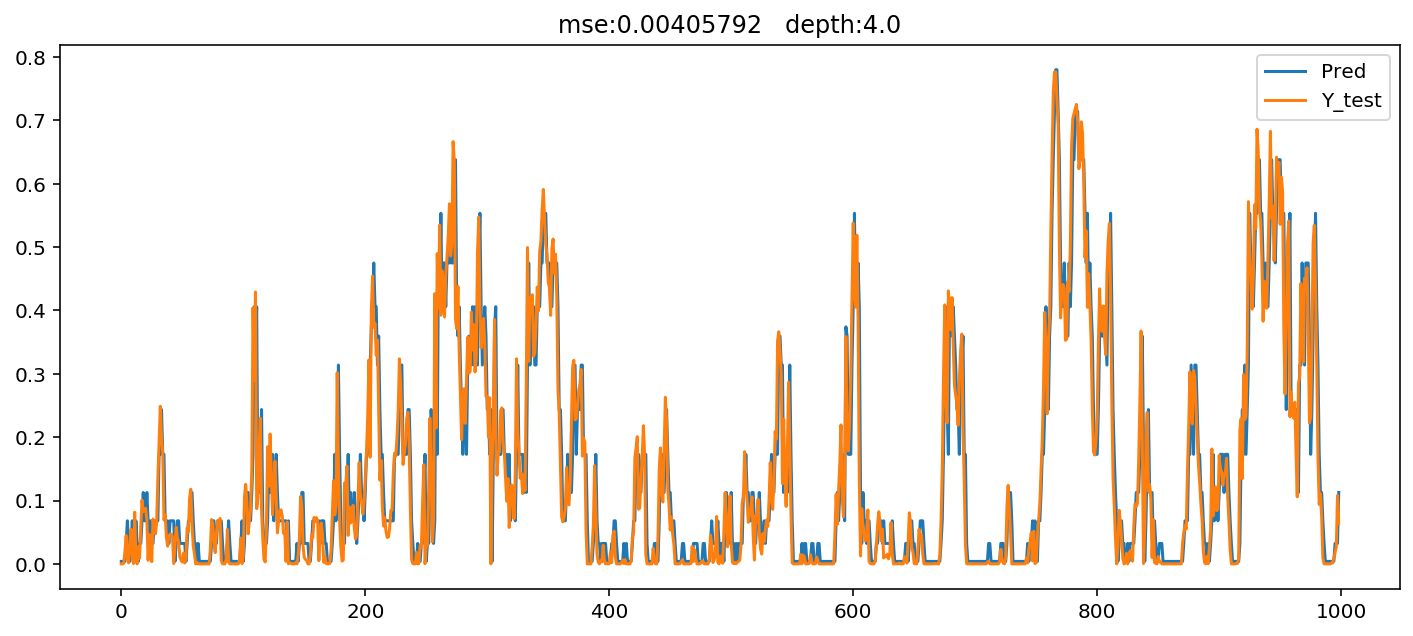

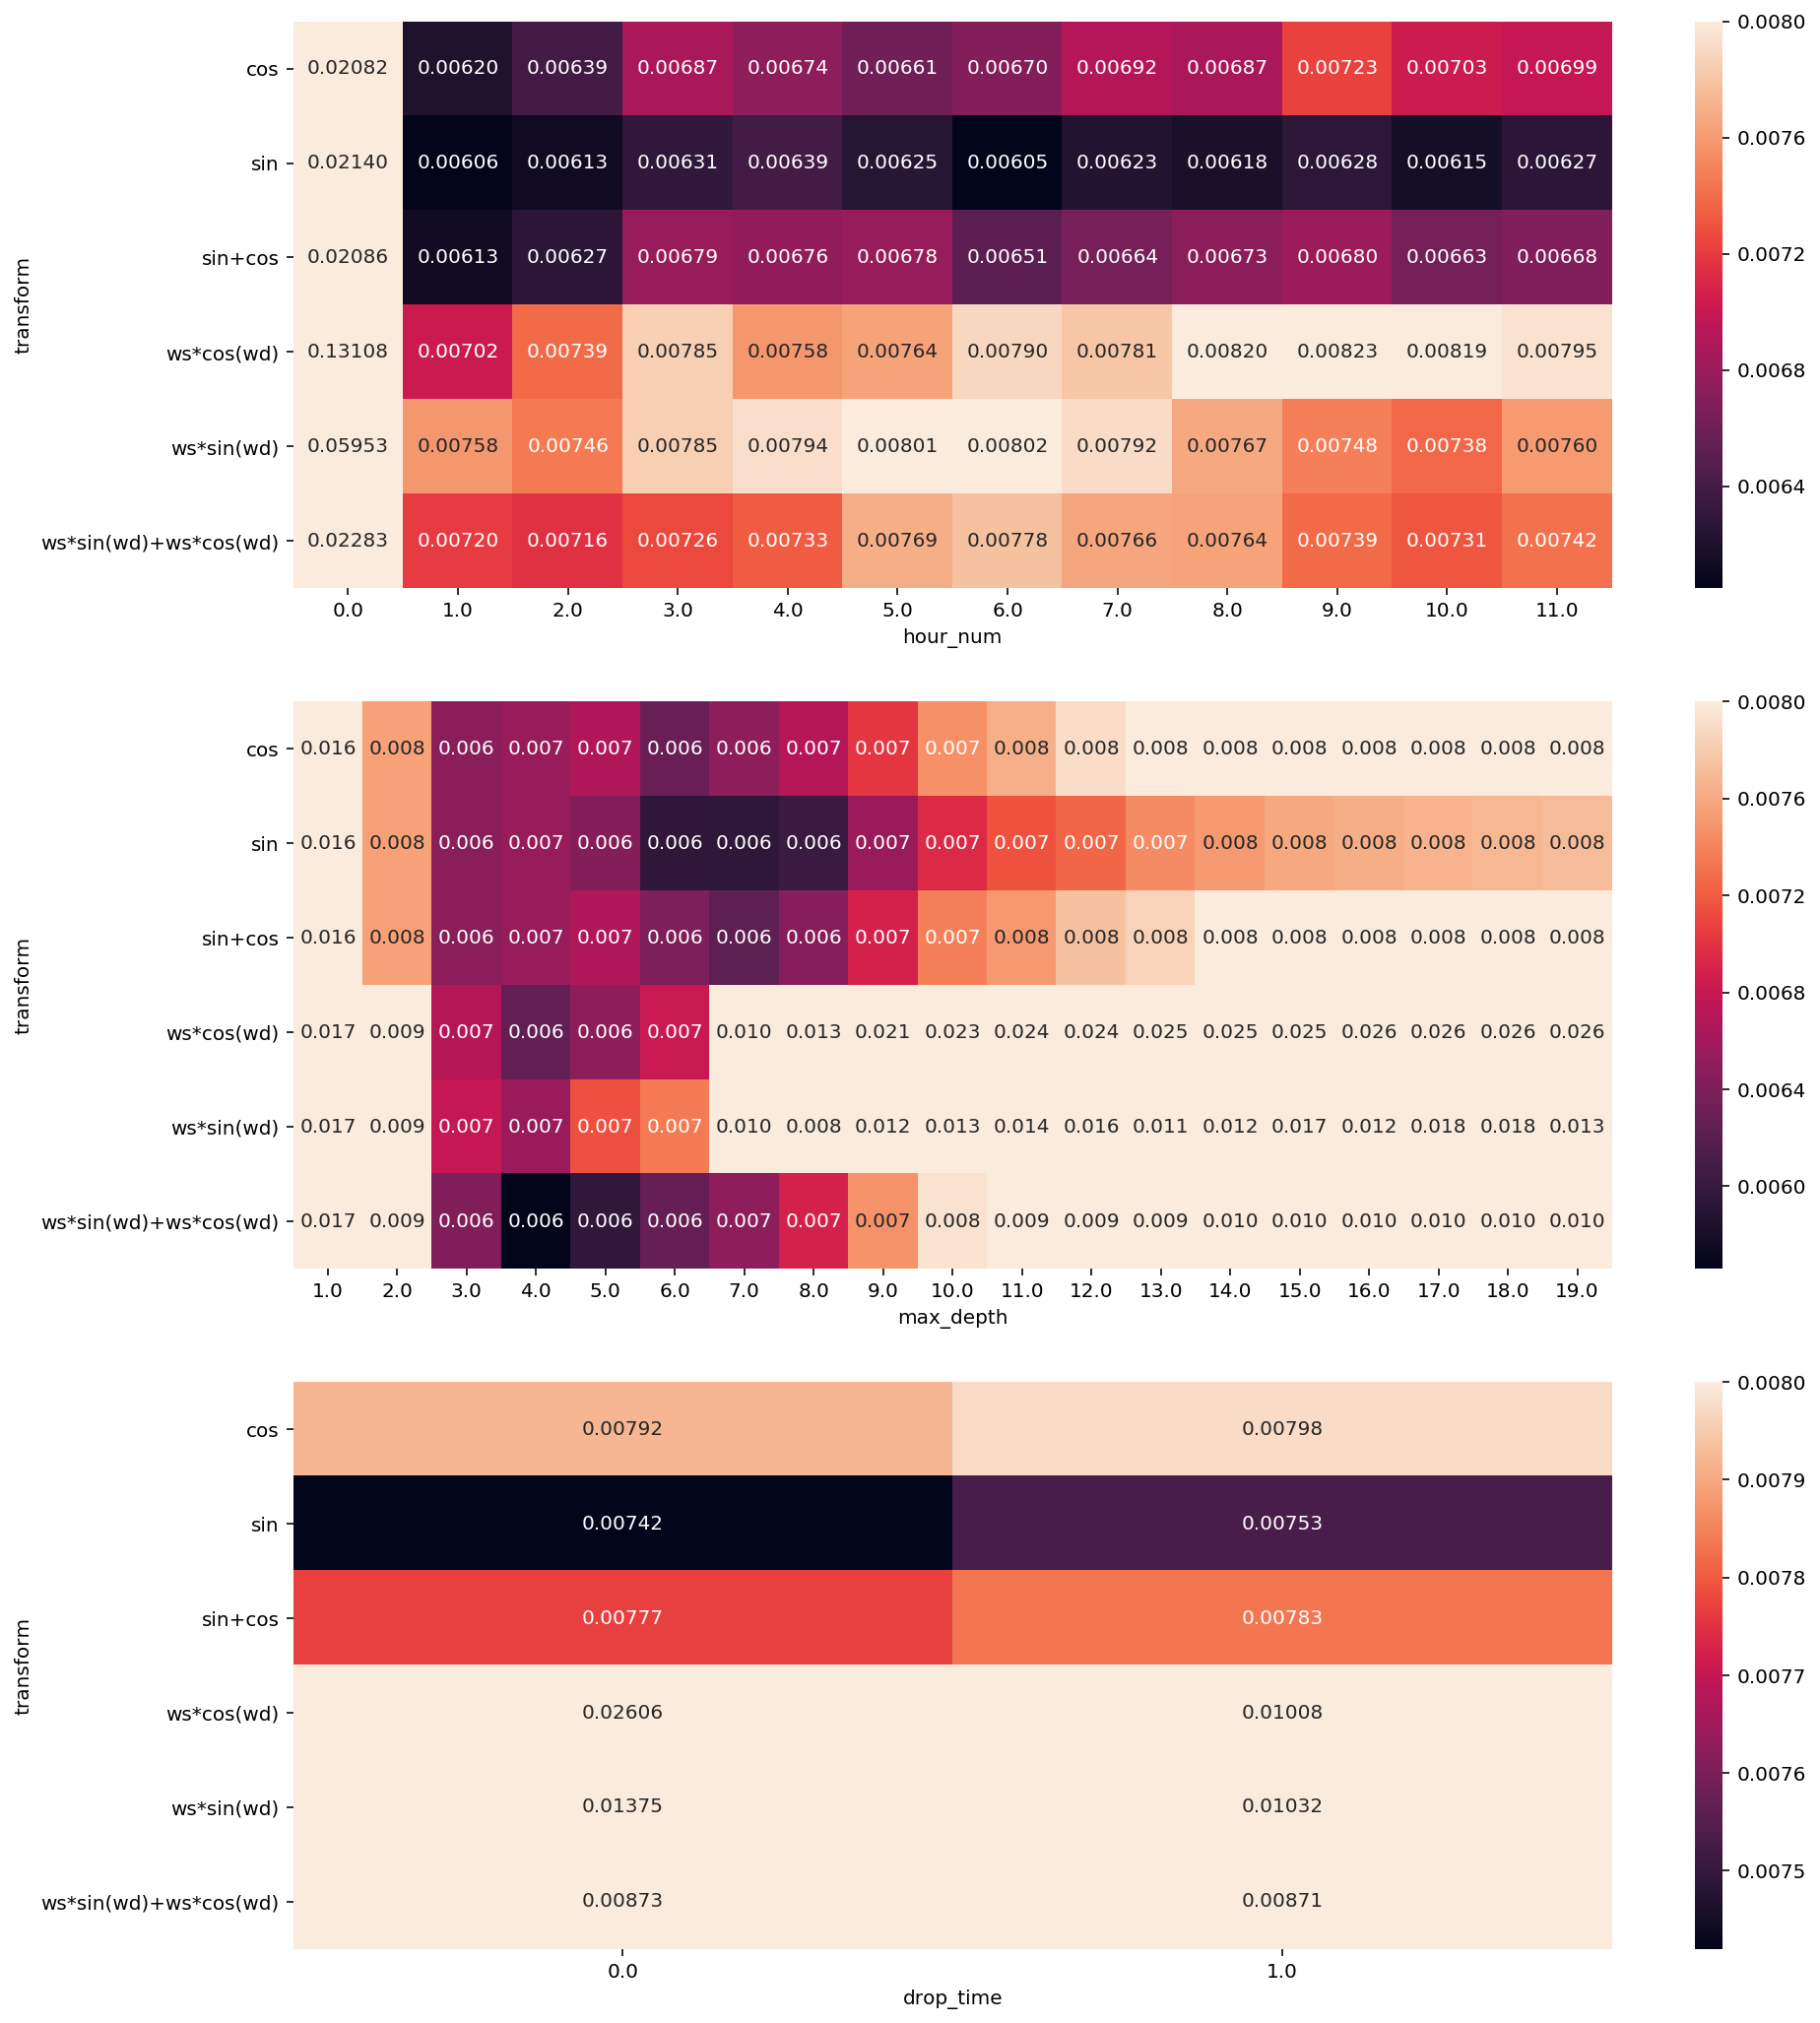

In [8]:
param_grid1 = {'transform': [None, 'sin', 'cos', 'sin+cos', 'ws*sin(wd)', 
                            'ws*cos(wd)', 'ws*sin(wd)+ws*cos(wd)'],
              'hour_num': np.arange(0,12),
              'drop_time': [True, False],
              'max_depth': np.arange(1,20)}
mse_df1, best_param1 = tree_grid_search1(param_grid1)

___

## 美国数据

### Minute

get_data(hour_num=0, transform='sin+cos', drop_time=True, drop_esle=False, scale=True)

Data: ['相近8个地点2012年数据', '20738-2012.csv'] 

Input space: Index(['wind_speed', 'air_temperature', 'surface_air_pressure', 'density',
       'sin(wd)', 'cos(wd)'],
      dtype='object')
train index: [3001, 7002] train_len: 4001
test index: [2000, 3001] test_len: 1001


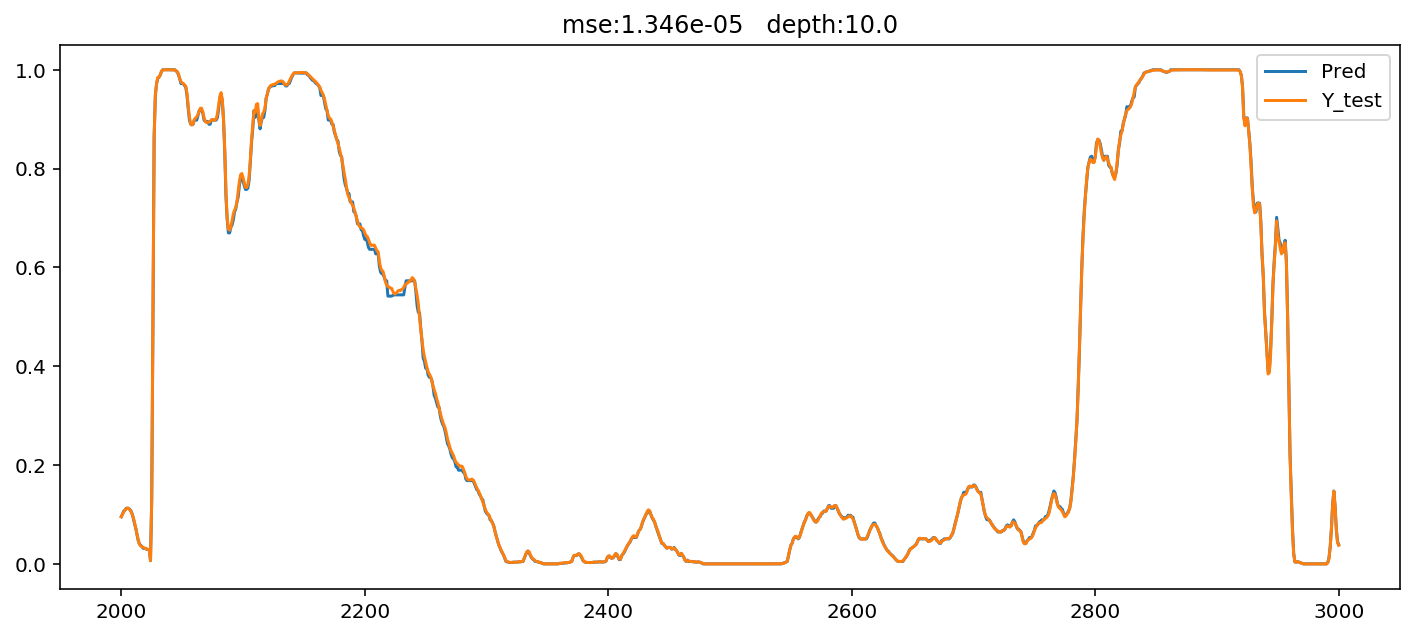

In [12]:
best_param =  {'drop_else': 0.0, 
               'drop_time': 1.0, 
               'hour_num': 0.0, 
               'max_depth': 10.0, 
               'mse': 2.5709866985355128e-05, 
               'transform': 'sin+cos'} 
tree_model_plot2(best_param, drop_minute=False)


get_data(hour_num=0, transform='sin+cos', drop_time=True, drop_esle=False, scale=True)

Data: ['相近8个地点2012年数据', '20738-2012.csv'] 

Input space:  Index(['wind_speed', 'air_temperature', 'surface_air_pressure', 'density',
       'sin(wd)', 'cos(wd)'],
      dtype='object') 

best_param:
 {'drop_else': 0.0, 'drop_time': 1.0, 'hour_num': 0.0, 'max_depth': 10.0, 'mse': 2.5709866985355128e-05, 'transform': 'sin+cos'} 

best_mse: 2.5709866985355128e-05


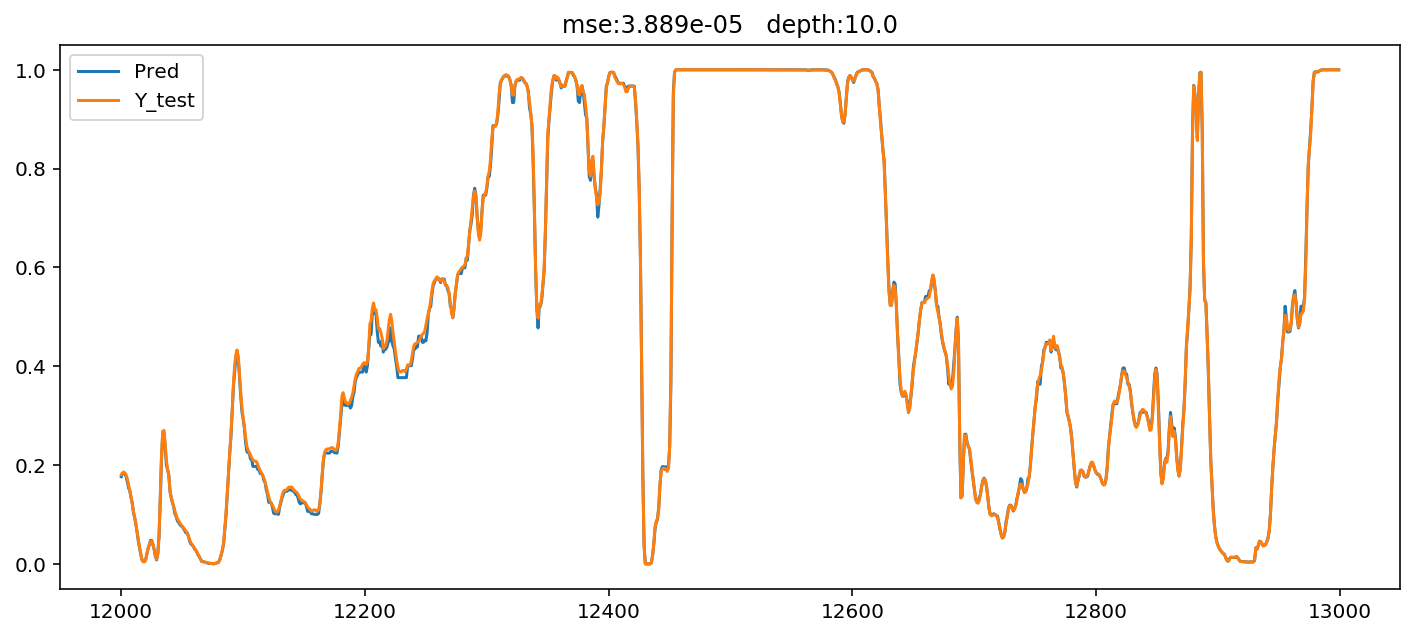

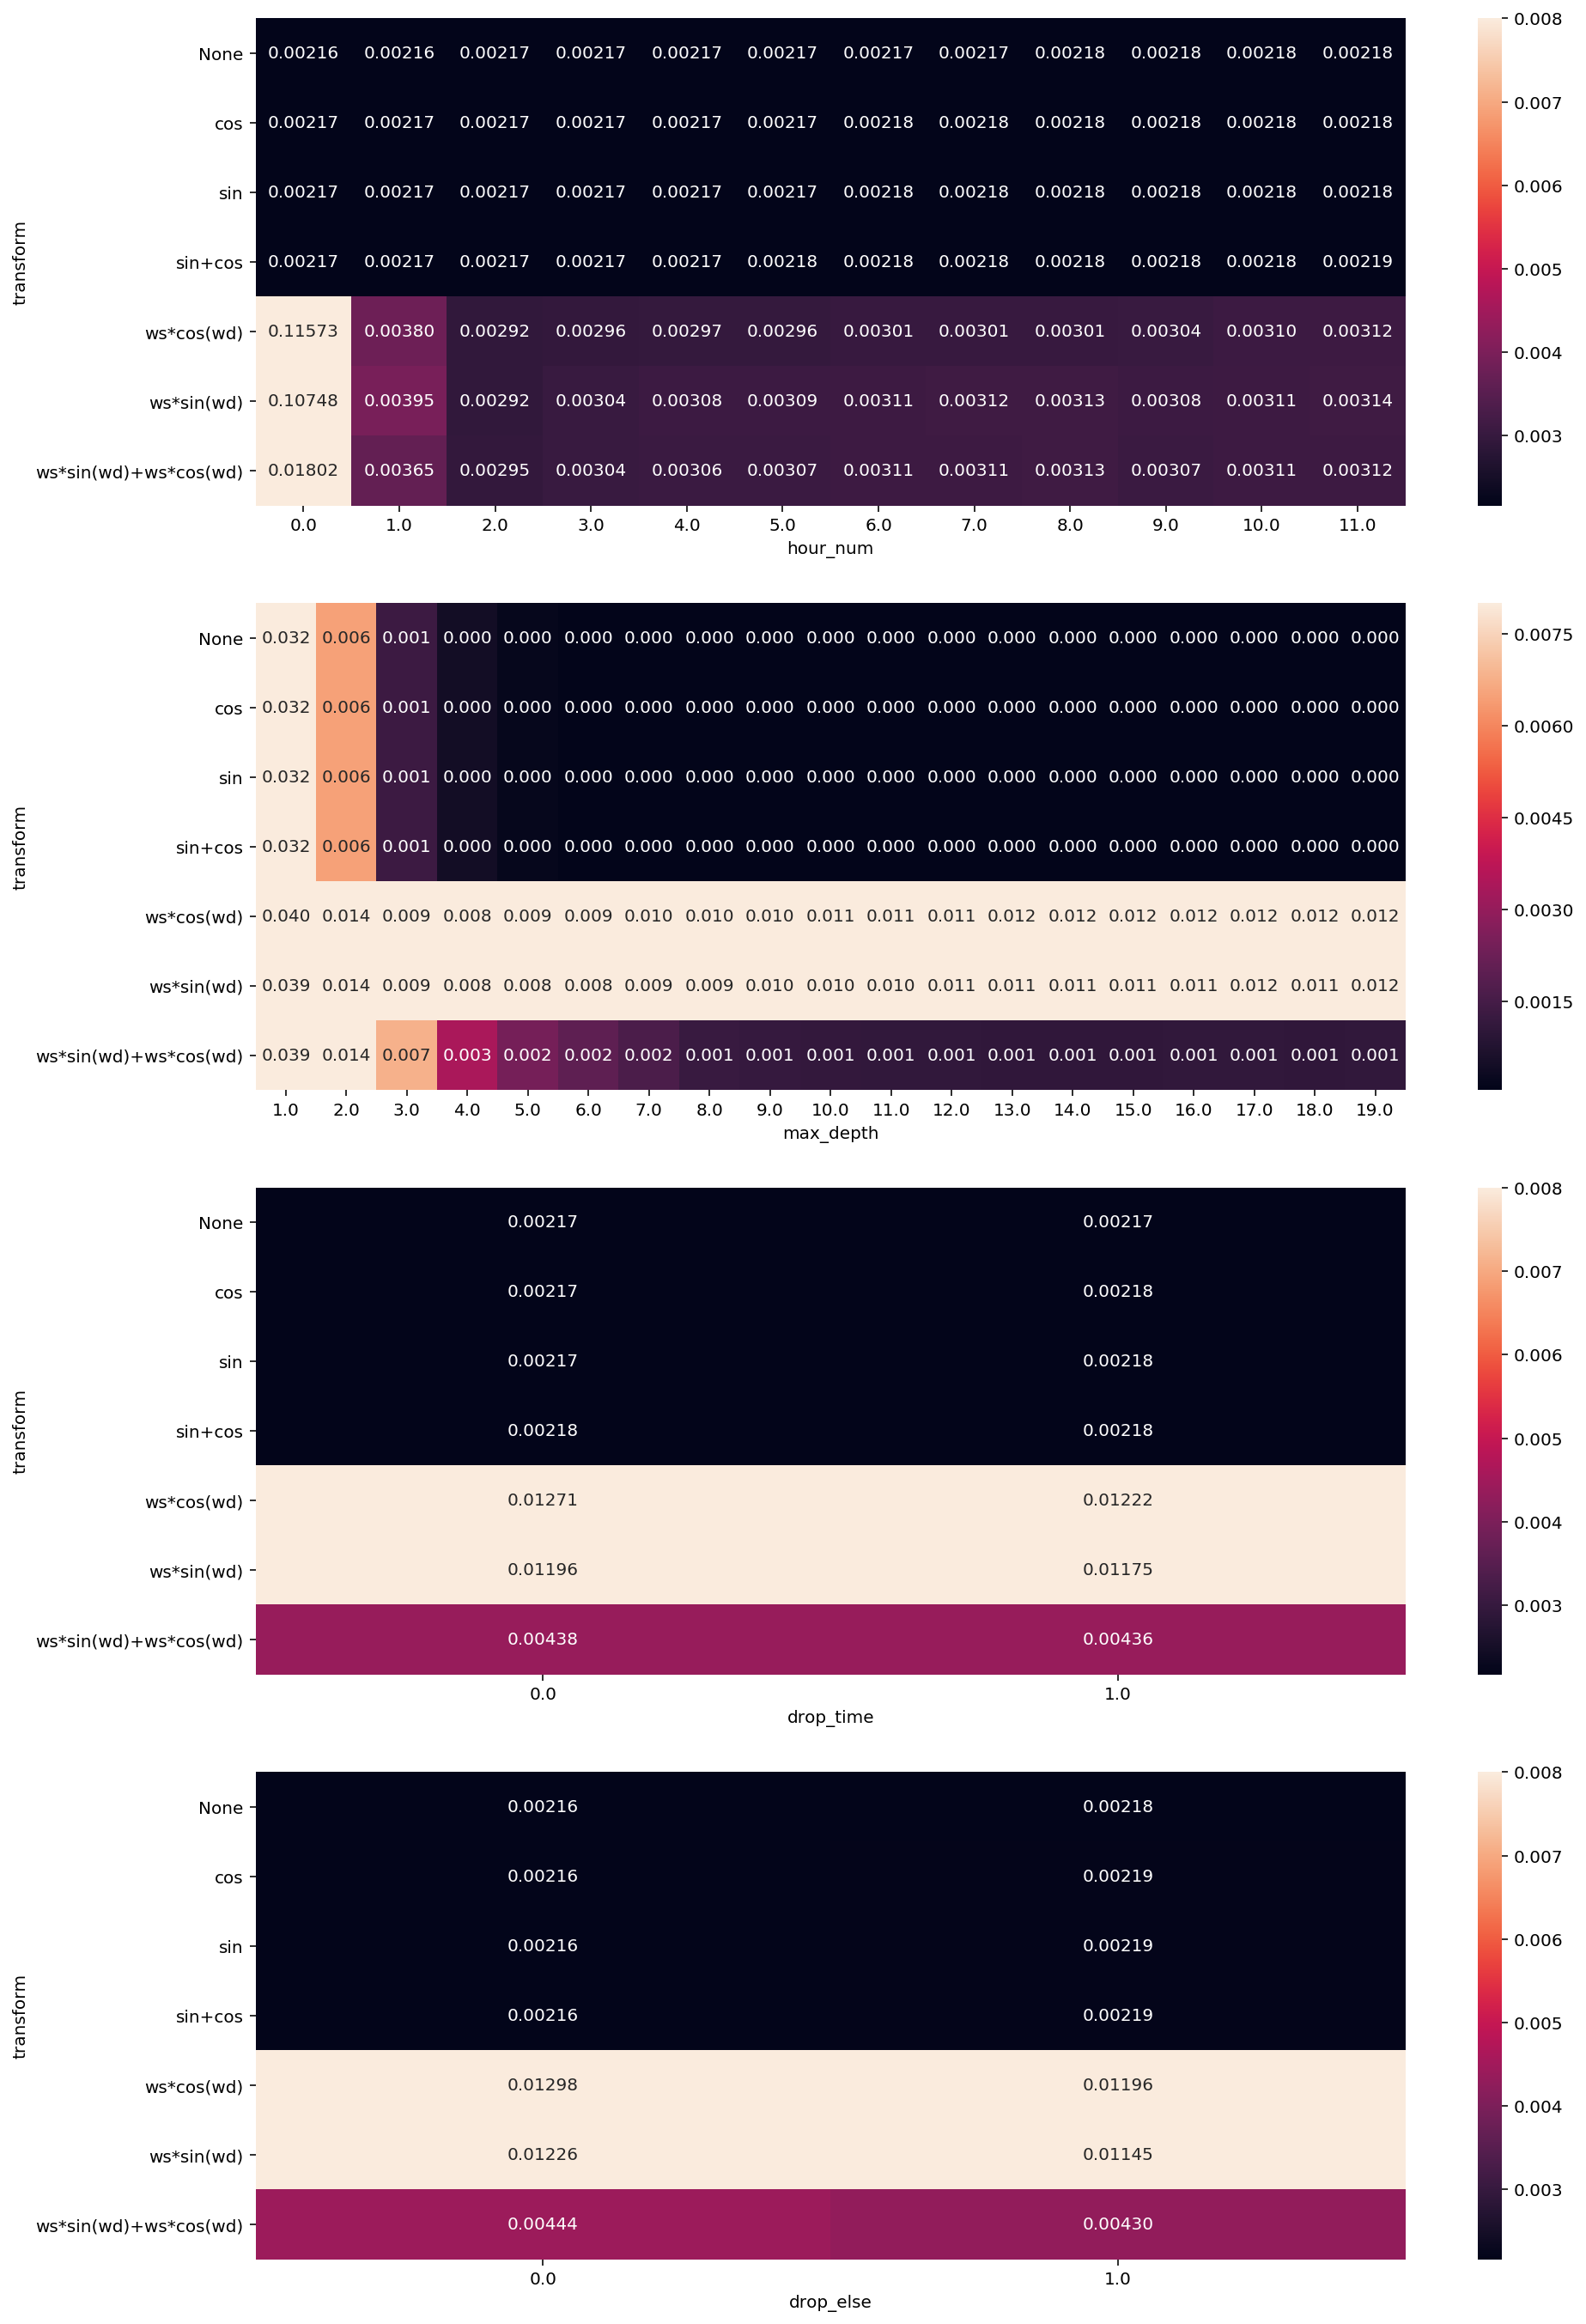

In [11]:
param_grid2 = {'transform': [None, 'sin', 'cos', 'sin+cos', 'ws*sin(wd)', 
                            'ws*cos(wd)', 'ws*sin(wd)+ws*cos(wd)'],
              'hour_num': np.arange(0,12),
              'drop_time': [True, False],
              'drop_else': [True, False],
              'max_depth': np.arange(1,20)}
mse_df2, best_param2 = tree_grid_search2(param_grid2, drop_minute=False)

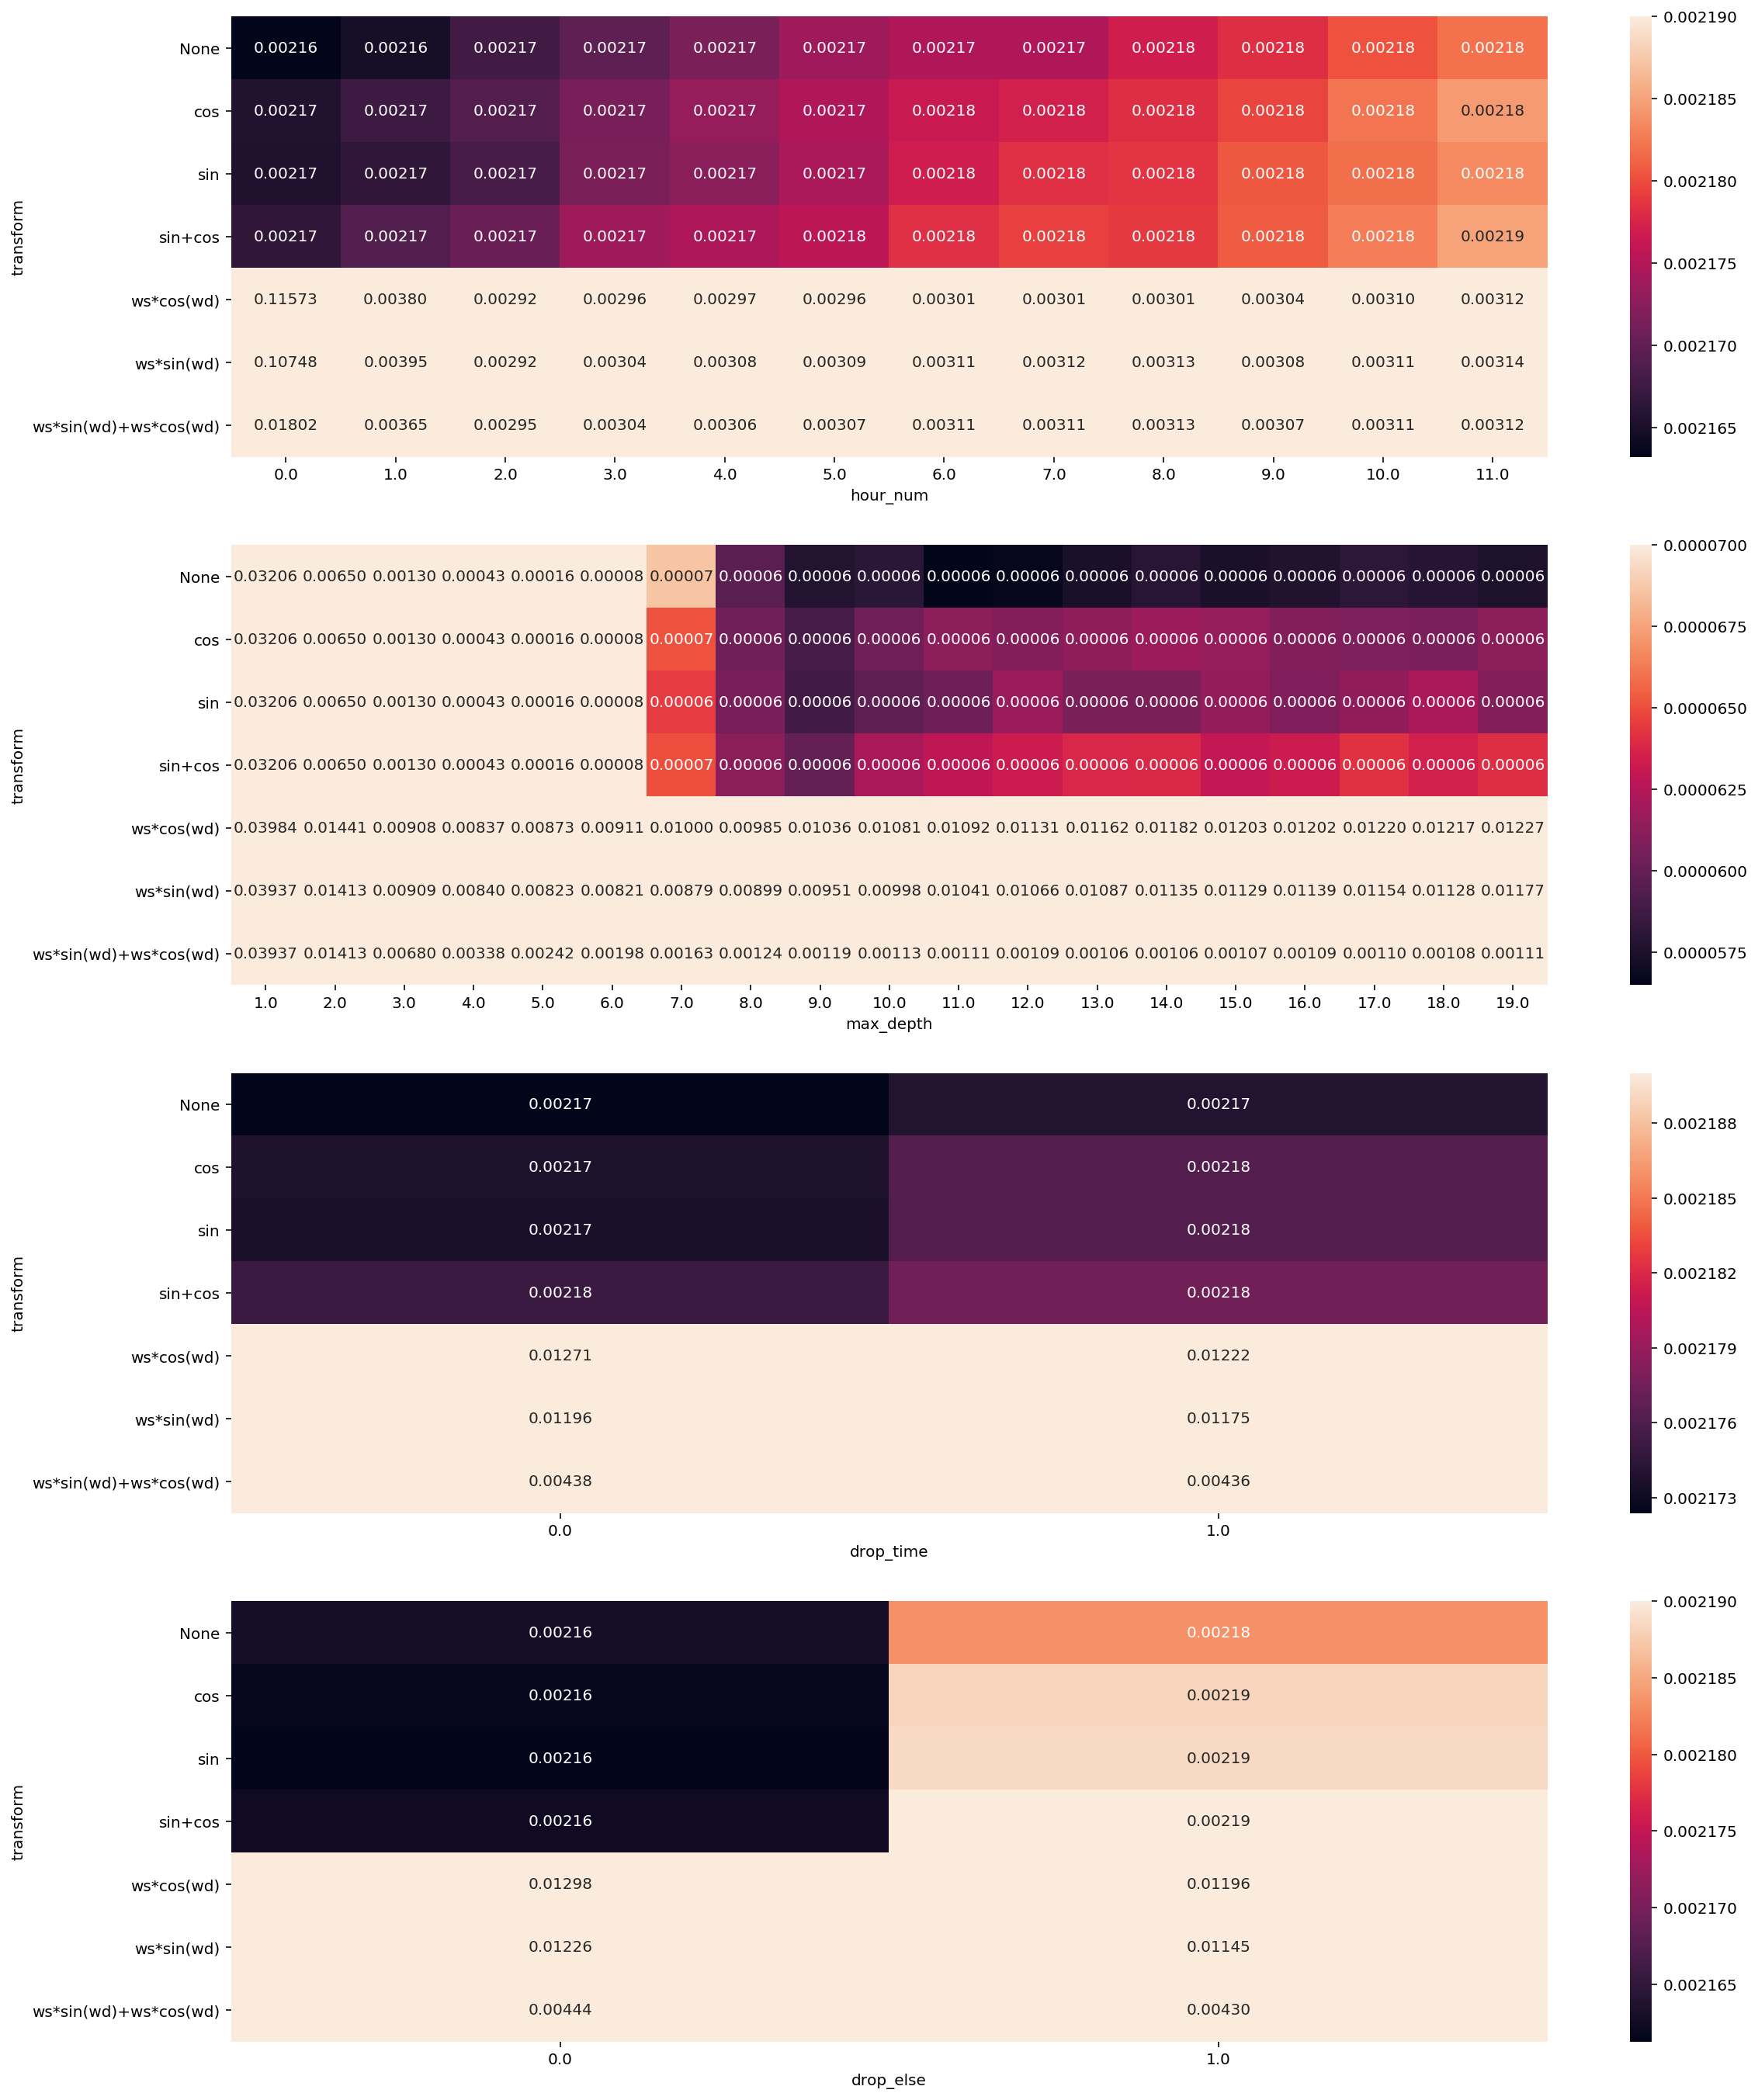

In [29]:
tree_heatmap2(mse_df2)

### Hour

get_data(hour_num=0, transform='cos', drop_time=True, drop_esle=False, scale=True)

Data: ['相近8个地点2012年数据', '20738-2012.csv'] 

Input space: Index(['wind_speed', 'air_temperature', 'surface_air_pressure', 'density',
       'cos(wd)'],
      dtype='object')
train index: [3001, 7002] train_len: 4001
test index: [2000, 3001] test_len: 1001


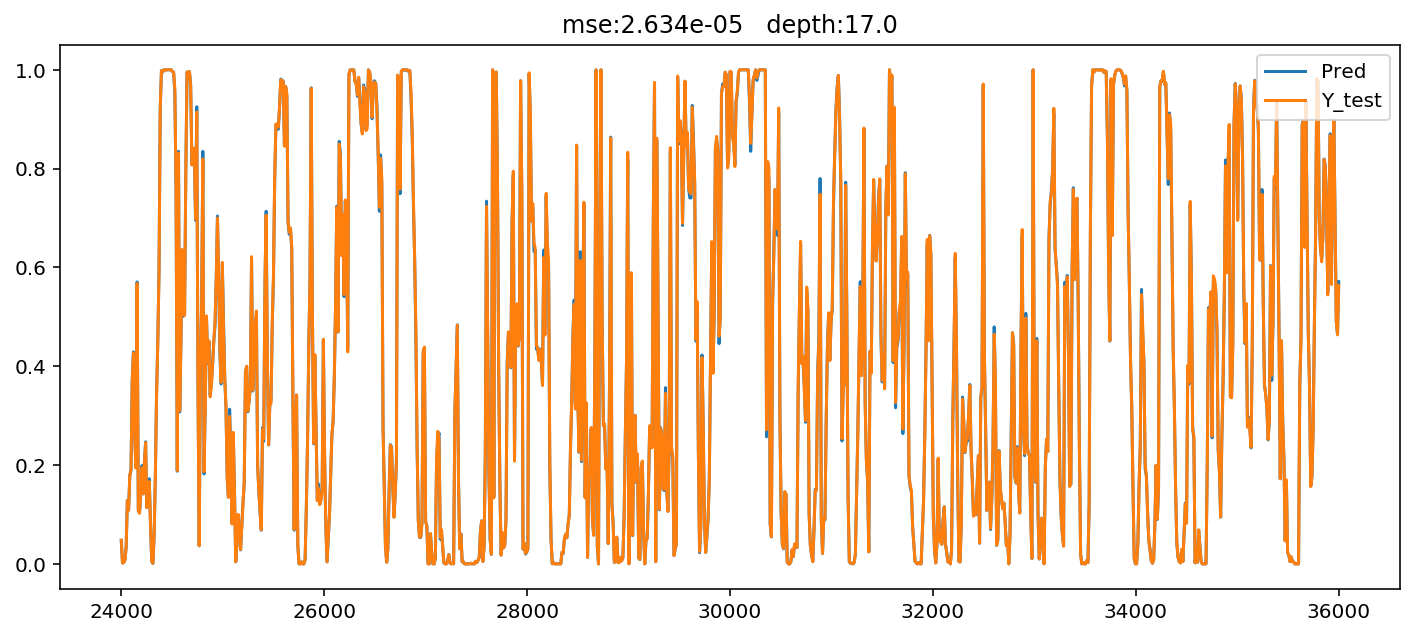

In [13]:
best_param =  {
    'drop_else': 0.0, 
    'drop_time': 1.0, 
    'hour_num': 0.0, 
    'max_depth': 17.0, 
    'transform': 'cos'} 
tree_model_plot2(best_param, drop_minute=True)


get_data(hour_num=0, transform='cos', drop_time=True, drop_esle=False, scale=True)

Data: ['相近8个地点2012年数据', '20738-2012.csv'] 

Input space:  Index(['wind_speed', 'air_temperature', 'surface_air_pressure', 'density',
       'cos(wd)'],
      dtype='object') 

best_param:
 {'drop_else': 0.0, 'drop_time': 1.0, 'hour_num': 0.0, 'max_depth': 17.0, 'mse': 2.316138201897016e-05, 'transform': 'cos'} 

best_mse: 2.316138201897016e-05


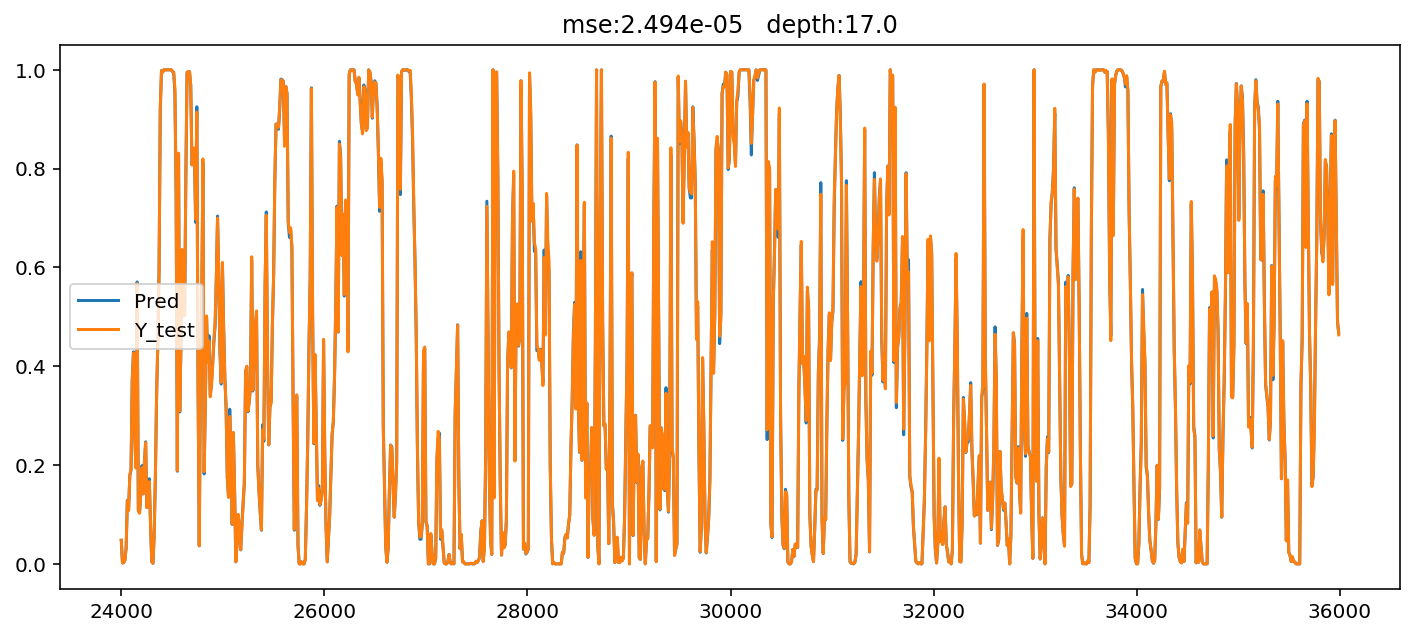

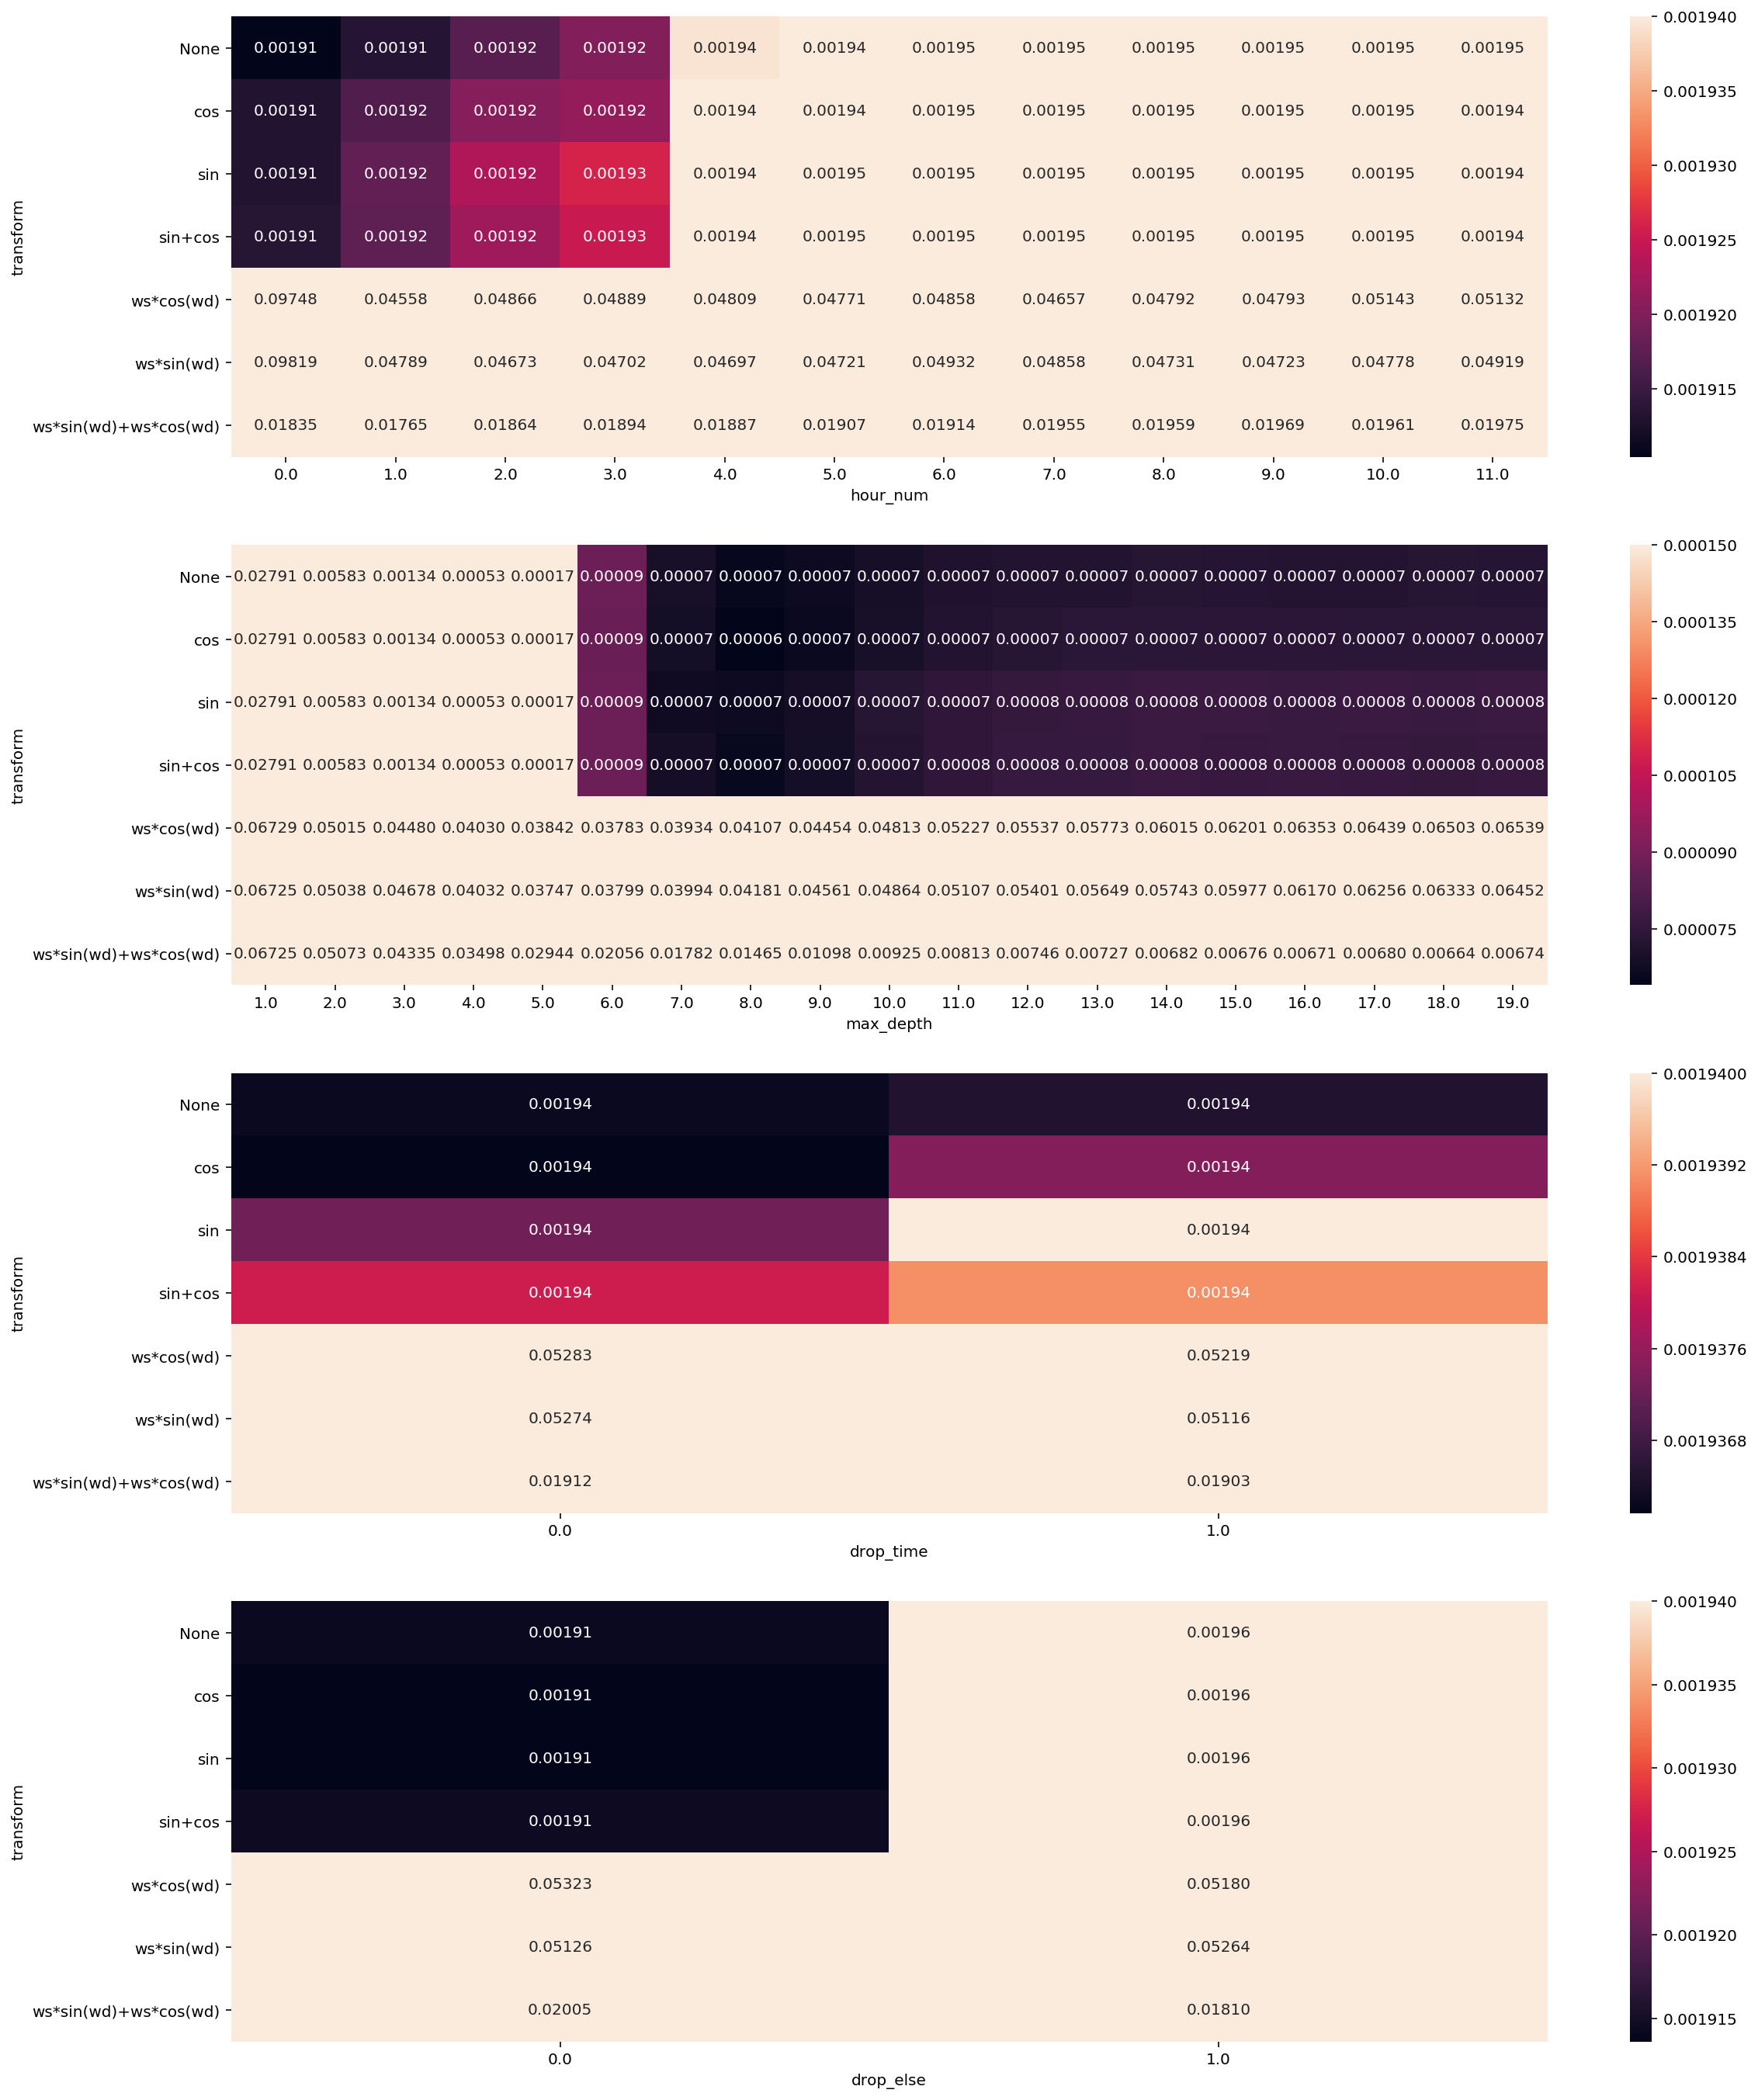

In [37]:
param_grid3 = {'transform': [None, 'sin', 'cos', 'sin+cos', 'ws*sin(wd)', 
                            'ws*cos(wd)', 'ws*sin(wd)+ws*cos(wd)'],
              'hour_num': np.arange(0,12),
              'drop_time': [True, False],
              'drop_else': [True, False],
              'max_depth': np.arange(1,20)}
mse_df3, best_param3 = tree_grid_search2(param_grid2, drop_minute=True)

In [43]:
def tree_heatmap2(mse_df):
    f, ax= plt.subplots(figsize=(19,24),nrows=4)
    sns.heatmap(mse_df.groupby(['transform','hour_num'])['mse'].mean().unstack(),
                ax=ax[0], vmax=0.00196, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','max_depth'])['mse'].mean().unstack(),
                ax=ax[1], vmax=0.00015, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_time'])['mse'].mean().unstack(),
                ax=ax[2], vmax=0.00196, annot=True, fmt='.5f')
    sns.heatmap(mse_df.groupby(['transform','drop_else'])['mse'].mean().unstack(),
                ax=ax[3], vmax=0.00196, annot=True, fmt='.5f')

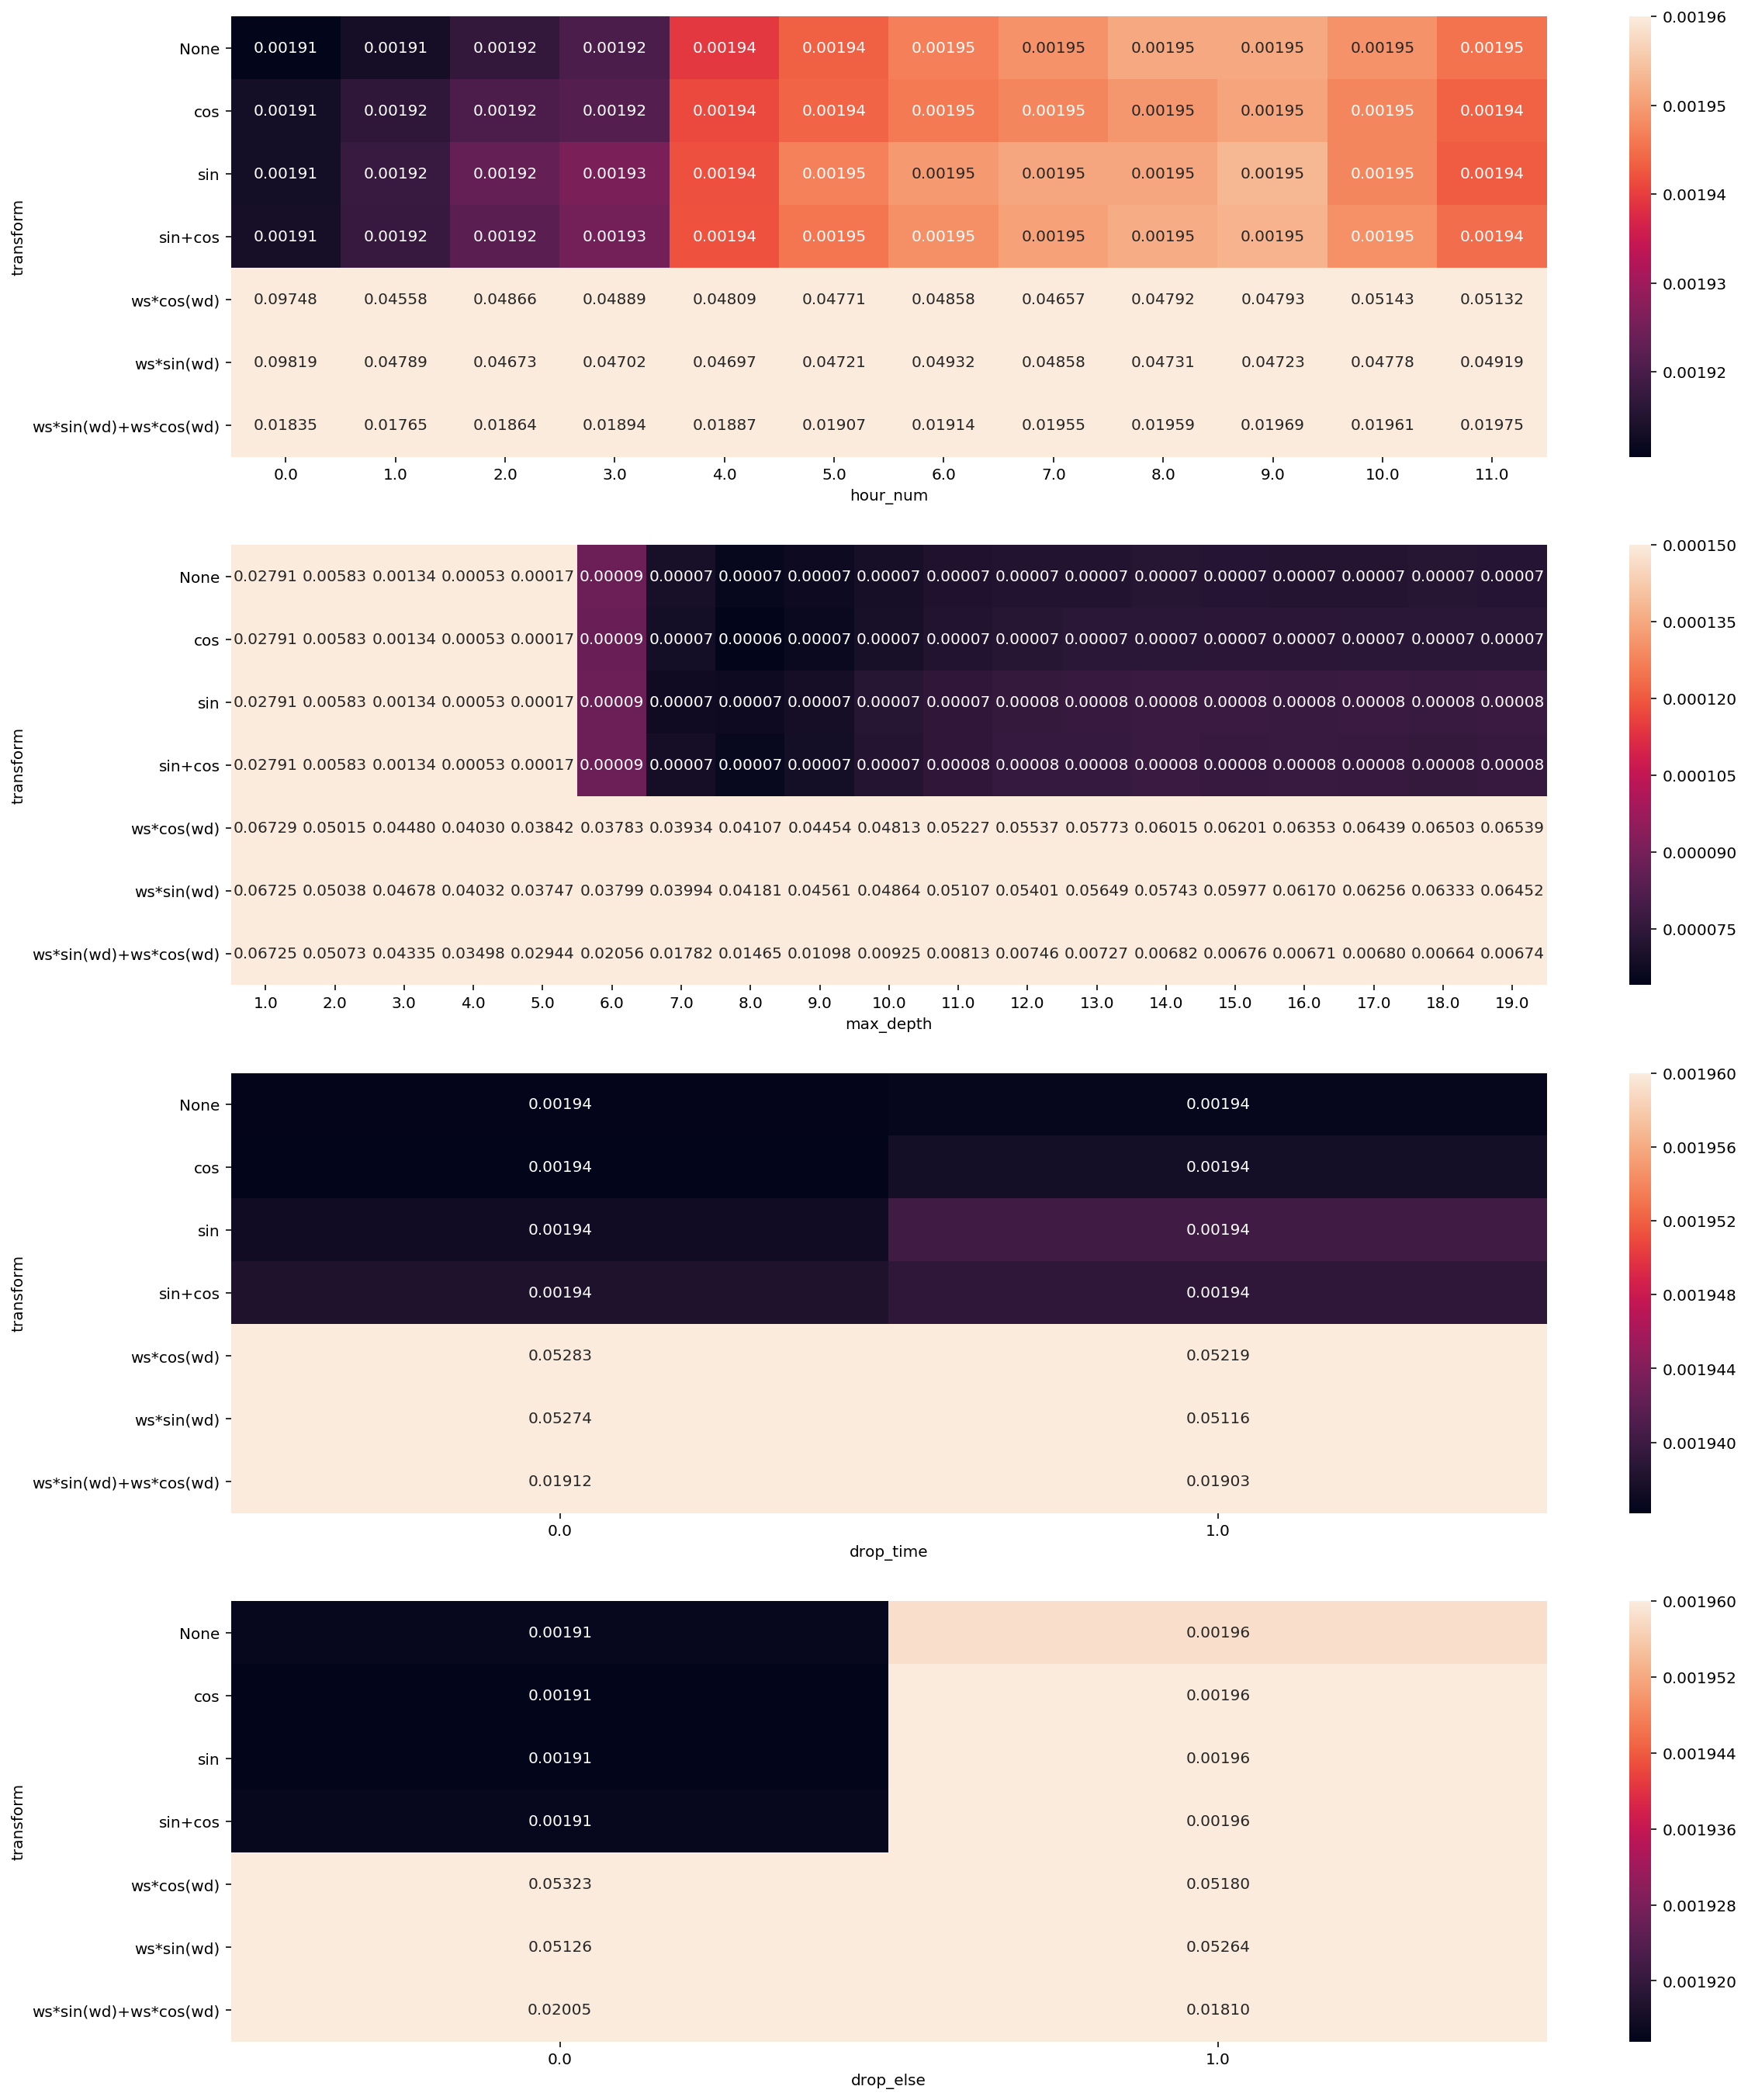

In [44]:
tree_heatmap2(mse_df3)